In [73]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
pn.extension()

pn.Row("Thermoelectric Dashboard").servable()
from tabulate import tabulate

In [75]:
# === Material properties for multiple thermoelectric materials ===
materials = {
    "Bi2Te3": {"S": 200e-6, "sigma": 1e5, "k": 1.5},
    "PbTe": {"S": 160e-6, "sigma": 1.2e5, "k": 2.0},
    "SnSe": {"S": 300e-6, "sigma": 5e4, "k": 0.6}
}


In [77]:
# === Time simulation: 10 minutes at 1-second resolution ===
time = np.linspace(0, 600, 600)  # seconds
T_cold = 300  # K
T_exhaust = 350 + 100 * np.sin(2 * np.pi * time / 300)  # exhaust temp fluctuation
delta_T = T_exhaust - T_cold
T_avg = (T_exhaust + T_cold) / 2  # for ZT calculation

# === Geometry and scaling ===
L = 0.005   # leg length (m)
A = 1e-6    # cross-sectional area (m²)
N_legs = 200  # scale to 200 thermoelectric legs

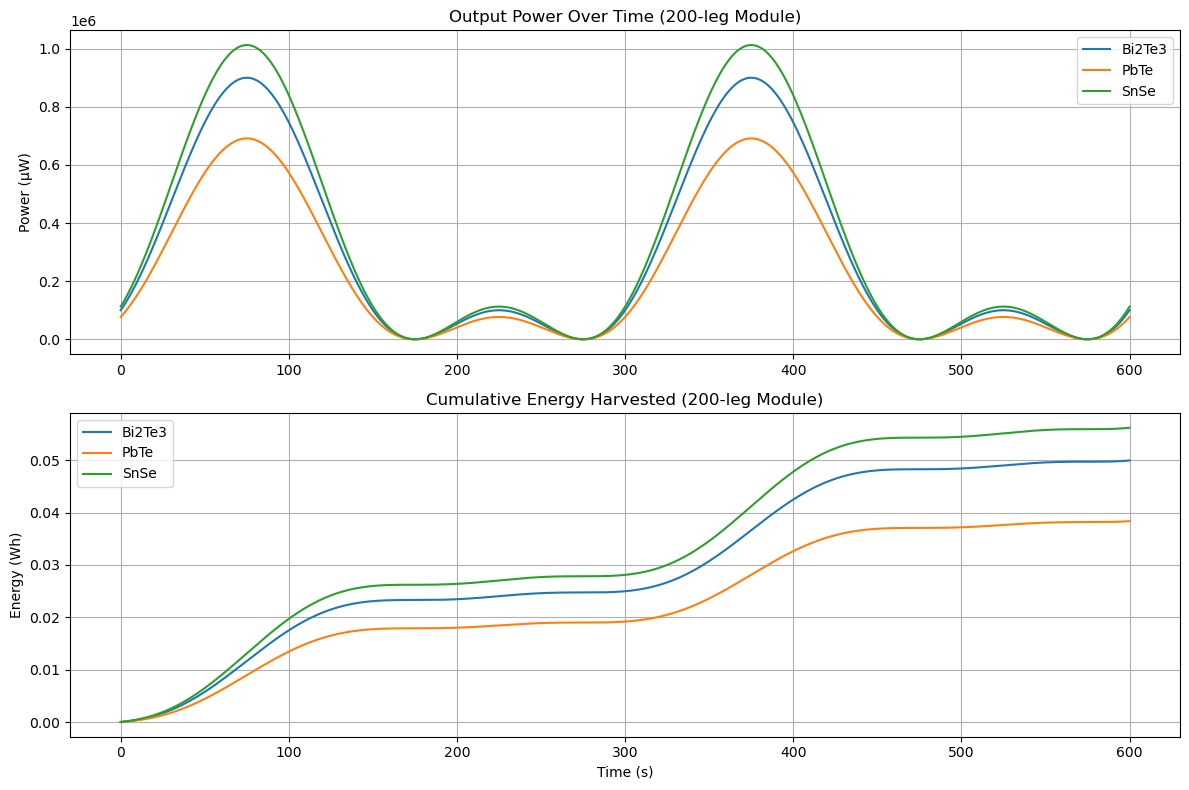

In [79]:
# === Prepare plots ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

results = []

for name, props in materials.items():
    S = props["S"]
    sigma = props["sigma"]
    k = props["k"]

    # === Internal resistance, voltage, power ===
    R_internal = L / (sigma * A)
    V_out = S * delta_T
    P_out = (V_out ** 2) / (4 * R_internal)

    # === Cumulative energy ===
    energy_cumulative = np.cumsum(P_out)  # J
    energy_wh = np.sum(P_out) / 3600 * N_legs  # scaled to full module

    # === Scale power to full module ===
    P_out_scaled = P_out * N_legs

    # === Calculate ZT (average) ===
    ZT_avg = (S ** 2 * sigma * np.mean(T_avg)) / k

    # === Plot results ===
    ax1.plot(time, P_out_scaled * 1e6, label=name)  # μW
    ax2.plot(time, energy_cumulative / 3600 * N_legs, label=name)  # Wh

    # === Save results ===
    results.append([
        name,
        f"{energy_wh:.4f}",
        f"{np.mean(P_out_scaled) * 1e6:.2f}",  # μW
        f"{np.max(P_out_scaled) * 1e6:.2f}",   # μW
        f"{ZT_avg:.2f}"
    ])

# === Format plots ===
ax1.set_title("Output Power Over Time (200-leg Module)")
ax1.set_ylabel("Power (μW)")
ax1.grid(True)
ax1.legend()


ax2.set_title("Cumulative Energy Harvested (200-leg Module)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Energy (Wh)")
ax2.grid(True)
ax2.legend()
plt.savefig("figures/plots.png")

plt.tight_layout()
plt.show()



In [80]:
# === Tabulate results ===
headers = ["Material", "Total Energy (Wh)", "Avg Power (μW)", "Max Power (μW)", "ZT (avg)"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

+----------+-------------------+----------------+----------------+----------+
| Material | Total Energy (Wh) | Avg Power (μW) | Max Power (μW) | ZT (avg) |
+----------+-------------------+----------------+----------------+----------+
|  Bi2Te3  |      0.0499       |   299666.67    |   899995.87    |   0.87   |
|   PbTe   |      0.0384       |   230144.00    |   691196.83    |   0.50   |
|   SnSe   |      0.0562       |   337125.00    |   1012495.36   |   2.44   |
+----------+-------------------+----------------+----------------+----------+


In [81]:
import pandas as pd

# Create a DataFrame from the results list
df_results = pd.DataFrame(results, columns=[
    "Material", "Total Energy (Wh)", "Avg Power (μW)", "Max Power (μW)", "ZT (avg)"
])

# Save the DataFrame to a CSV file
df_results.to_csv("results/thermoelectric_module_results.csv", index=False)